### Install pre-defined functions to prepare retail sales data 

In [1]:
import os
import shutil
import sagemaker.amazon.common as smac    
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3

In [2]:
#Navidate to deep-ar directory to install the deepar package containing commonly used functions
path = ".."
os.chdir(path)

#install predefined functions
!pip install .

#Navigate to the parent directory to train the DeepAR model
# org_path = ".."
# os.chdir(org_path)

!pwd

Processing /home/ec2-user/SageMaker/DeepAR/Final/deep-ar
  Running setup.py bdist_wheel for deepar ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3a/79/48/5c4dfb39692cbccf9e13a11f7b63564ae85fc1658e1fd526cc
Successfully built deepar
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/home/ec2-user/SageMaker/DeepAR/Final/deep-ar


In [3]:
import deepar as da

### Prepare training and test dataset in JSON format

In [4]:
train_key      = 'deepar_sales_training.json'
test_key       = 'deepar_sales_test.json'
#Prediction and context length for training the DeepAR model
prediction_length = 9
salesfn = 'data/store20_sales.csv'

salesdf = da.retailsales.prepareSalesData(salesfn)
testSet = da.retailsales.getTestSales(salesdf, test_key)
trainingSet = da.retailsales.getTrainSales(salesdf, train_key, prediction_length)

### Upload Input data to S3

In [5]:
bucket         = 'ai-in-aws'
prefix         = 'sagemaker/deepar-weekly-sales'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

sagemaker_session = sagemaker.Session()

train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

### Configuring the training job

In [7]:
role = get_execution_role()
output_path = r's3://{0}/{1}'.format(bucket, output_prefix) 

container = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

deepAR = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=1,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sagemaker_session)

### Defining hyper parameters

In [8]:
hyperparameters = {
    "time_freq": 'W', # weekly series
    "context_length": prediction_length, # how many data points are we going to look at before predicting
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40", # of cells to use in each of the hidden layers
    "num_layers": "2", # of hidden layers
    "likelihood": "gaussian",
    "epochs": "300", # max number of passses over the training data
    "mini_batch_size": "32", # size of the mini batches used during training
    "learning_rate": "0.00001",
    "dropout_rate": "0.05", #for each iteration, a random subset of hidden neurons are not updated
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

deepAR.set_hyperparameters(**hyperparameters) #** = arbitrary number of arguments to functions

### Training the model

In [17]:
data_channels = {"train": train_path, "test": test_path}
deepAR.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2018-12-05-17-33-07-661


2018-12-05 17:33:07 Starting - Starting the training job...
2018-12-05 17:33:11 Starting - Launching requested ML instances......
2018-12-05 17:34:20 Starting - Preparing the instances for training......
2018-12-05 17:35:31 Downloading - Downloading input data..

2018-12-05 17:36:03 Training - Training image download completed. Training in progress.
2018-12-05 17:36:03 Uploading - Uploading generated training modelArguments: train
[12/05/2018 17:35:54 INFO 140654853965632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', 


2018-12-05 17:36:10 Completed - Training job completed
Billable seconds: 39


### Deploy the Model

In [18]:
deepAR_predictor = deepAR.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: forecasting-deepar-2018-12-05-17-37-03-324
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2018-12-05-17-33-07-661


---------------------------------------------------------------------------!

### Consume the Model

Predicted Sales:  [92707.65625, 101316.90625, 86202.3984375, 87715.5625, 95967.359375, 101363.71875, 106354.90625, 94017.921875, 103476.71875]
Actual Sales:  [100422.86, 94987.08, 90889.75, 115695.71, 100372.02, 96616.19, 93460.57, 99398.64, 105059.88]


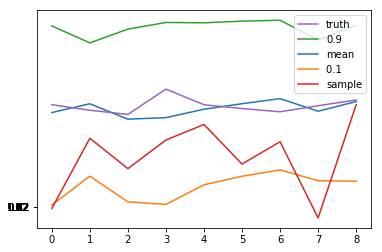

In [4]:
#Predict last 9 weeks of a department and compare to ground truth

deepAR_predictor.content_type = 'application/json'
dept = 90 

prediction_data = da.salesinference.buildInferenceData(dept, trainingSet, testSet)
#print(prediction_data)

result = deepAR_predictor.predict(prediction_data)

y_mean, y_q1, y_q2, y_sample = da.salesinference.getInferenceSeries(result)
print("Predicted Sales: ", y_mean)
print("Actual Sales: ", list(testSet[dept]['Weekly_Sales'][134:]))

da.salesinference.plotResults(prediction_length, result, truth=True, truth_data=testSet[dept]['Weekly_Sales'][134:], truth_label='truth')